# Data preparation
---
In this notebook, we will go over the raw data and how we put the data together and prepare them for our analysis. 
data sources:

In [1]:
#imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from os import listdir
import datetime as dt

## Data source and structure

## Read/combine listings


Let us start with the listing files that contain information about different listings. These files are scraped on a quarterly basis and contain various information about airbnb listings. In this section we will check to make sure that all the files we are using have the same columns. At the end, we will combine them into one dataframe.


In [2]:
# read the data from different .csv files, and concatenate them together.
first_call = True
for file_name in listdir('./../data/')[::-1]:
    if first_call:
        print(f'... file {file_name} is being read')
        df = pd.read_csv('./../data/'+file_name)
        print(f'\tit has {df.shape[0]} rows and {df.shape[1]} column')
        main_columns = df.columns
        first_call = False
        continue
    print(f'... file {file_name} is being read')
    df1 = pd.read_csv('./../data/'+file_name)
    print(f'\tit has {df1.shape[0]} rows and {df1.shape[1]} column')
    columns = df1.columns
    # check if columns in different csv files are exactly the same
    if (columns != main_columns).any():
        for col in columns:
            if col not in main_columns:
                print(f'column {col} in the new .csv file does not have an equivalent in main dataframe')
        for col in main_columns:
            if col not in columns:
                print(f'column {col} in the datafram does have an equivalent in the new .csv file')
        print(f'!!! ERROR !!! columns in the {file_name} dont match the main dataframe')
        break
    df = pd.concat([df, df1], axis=0)
print(f'Our data has a total of {df.shape[0]} rows and {df.shape[1]} column')

... file listings_12_15_23.csv is being read
	it has 15419 rows and 75 column
... file listings_091023.csv is being read
	it has 14861 rows and 75 column
... file listings_061023.csv is being read
	it has 14694 rows and 75 column
... file listings_031623.csv is being read
	it has 14368 rows and 75 column
Our data has a total of 59342 rows and 75 column


In [3]:
df.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20231215200307,2023-12-16,city scrape,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,NaN,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.83,4.73,4.79,NaN,f,1,1,0,0,3.71
1,5769,https://www.airbnb.com/rooms/5769,20231215200307,2023-12-16,previous scrape,Home in Austin · ★4.91 · 1 bedroom · 1 bed · 1...,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.94,4.76,4.92,NaN,f,1,0,1,0,1.76
2,6413,https://www.airbnb.com/rooms/6413,20231215200307,2023-12-16,previous scrape,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,NaN,Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/miso/Hosting-...,13879,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.70
3,6448,https://www.airbnb.com/rooms/6448,20231215200307,2023-12-16,city scrape,Guesthouse in Austin · ★4.97 · 1 bedroom · 2 b...,NaN,The neighborhood is fun and funky (but quiet)!...,https://a0.muscache.com/pictures/4513152/4ffc1...,14156,...,4.97,4.97,4.89,NaN,t,1,1,0,0,2.09
4,8502,https://www.airbnb.com/rooms/8502,20231215200307,2023-12-16,city scrape,Guest suite in Austin · ★4.56 · 1 bedroom · 1 ...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,25298,...,4.87,4.67,4.60,NaN,f,1,1,0,0,0.30


## Modeling occupancy rate

One of the challenges we have is to figure out the occupancy rate for a listing. Occupancy rate is the percentage of the nights a listing is reserved. If we multiply this number by today days (in the period of interest) and also by listing price, we can calculate the amount of money earned from the listing over the given period of time. This number is not published by airbnb and we need to be able to estimate it from different sources. There are various ways to estimate this number that we will discuss here:

1. **Use the number of days a listing is available on the calendar:**<br>
In this approach, we will look at the data scrapped from airbnb and see how many days in the calendar the listing is available for the next month, or two or so and 'assume' the number of days a listing is not available is in fact the number of days the listing is booked. This could cause several issues for us. Firstly, if the listing is not available, it could be either it is reserved by some guests or the host has not put it for rent in those specific dates, so it could be multiple factors. In addition to that, our current scrap has availability for 30, 60, 90, and 365 days from the day of scrapping the data. This means if we use 30 days as our reference, we will be missing the reservations that are made in less than 30 days. Another problem is that since our data is scraped once in every 3 months, when using 30 days data, we will have to use the same estimate for the 2nd and 3rd month (using 60 and 90 days availability is not a good idea either as it requires very far in advance booking). 

2. **Estimate the occupancy rate using other factors:** <br>
In this case, we will try to use other information from the listing to estimate the occupancy rate. In this project, we will be using the model presented by Budget and Legislative Analyst’s Office in San Francisco ([source](https://sfbos.org/sites/default/files/FileCenter/Documents/52601-BLA.ShortTermRentals.051315.pdf)). The basis of this model revolves around the fact that if we know what percentage of airbnb guests leave a review after using the property, then when we have the total number of reviews (and also the average number of stays for each guest for each booking), then we can find the total number of nights a property has been booked and diving it by the total number of nights the property is listed, we can find the occupancy rate. This model requires a series of assumptions. The first one would be to assume what percent of guests leave a review on airbnb. [Sources](http://insideairbnb.com/data-assumptions) have indicated that Airbnb at some point has mentioned that about 72% of the guests leave a review. However, there are some other [reports](https://sfbos.org/sites/default/files/FileCenter/Documents/52601-BLA.ShortTermRentals.051315.pdf) showing the review rate as low as 30% in cities like NYC. Also discussions in forums and resources indicate a number between 30 to 80% ([source](https://blog.keycafe.com/should-airbnb-hosts-ask-guests-to-leave-a-review/#:~:text=The%20average%20review%20rate%20according,a%20review%20from%20your%20guests.)). In this work, we will use all of these numbers and compare them and will decide on which number to use. <br>
Another import assumption in this model is number of nights per booking. This number for San Francisco is mentioned to be 5 ([source](https://sfbos.org/sites/default/files/FileCenter/Documents/52601-BLA.ShortTermRentals.051315.pdf)). While in Austin, some [websites](https://www.alltherooms.com/) report the average booking per night to be 7 for the last three month (as of Jan 2024), some other [resources](http://insideairbnb.com/data-assumptions) have used 3 days for cities without explicit information. We have opted to go with 5 days in this work (an average value). 




**NOTES:** <br>
If the minimum number of stays in a listing is more that 5 days (our nights per reservation), we will use the minimum stay to calculate the occupancy rate, but will cap the occupancy rate to a maximum of 70% per the highly occupied hotels. 

Let us start calculating the occupancy rate.

First, we will find the monthly occupancy rate by the number of nights the booking is not available in 30 days (max occupancy 0.7)


In [4]:
# first, we will find the monthly occupancy rate by the number 
# of nights the booking is not available in 30 days (max occupancy 0.7)
df['occ_rate_calendar'] = df['availability_30'].apply(lambda x: min((30-x)/30, 0.7))
df['occ_rate_calendar']

0        0.300000
1        0.700000
2        0.700000
3        0.666667
4        0.500000
           ...   
14363    0.266667
14364    0.200000
14365    0.300000
14366    0.166667
14367    0.100000
Name: occ_rate_calendar, Length: 59342, dtype: float64

Now, let us create some columns with the formula we mentioned above for the occupancy rate. First we will start with with data about the date the host starting hosting and the date of the last review.

In [5]:
# convert some dates to datetime object
df['last_scraped'] = pd.to_datetime(df['last_scraped'])
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [6]:
print(df['host_since'].isna().sum())
print(df['last_review'].isna().sum())

9
12242


It is interesting to see about 12000 listings dont have a date for the last review. Let us dive deeper into those listings.

In [7]:
no_last_review = df[df['last_review'].isna()]
no_last_review.isna().sum().sort_values(ascending=False).head(30)

neighbourhood_group_cleansed    12242
reviews_per_month               12242
calendar_updated                12242
first_review                    12242
license                         12242
last_review                     12242
bathrooms                       12242
review_scores_accuracy          12232
review_scores_location          12232
review_scores_communication     12232
review_scores_checkin           12232
review_scores_rating            12232
review_scores_cleanliness       12232
review_scores_value             12232
neighbourhood                    7087
neighborhood_overview            7087
host_about                       5821
host_response_time               5107
host_response_rate               5107
host_acceptance_rate             4909
bedrooms                         4488
description                      3275
host_location                    2677
host_neighbourhood               1434
price                             989
has_availability                  989
host_is_supe

Let us see if these listing have any review at all or not.

In [8]:
no_last_review['number_of_reviews'].describe()

count    12242.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: number_of_reviews, dtype: float64

As we can see, the listings with no last review date indeed don't have any review. Let us see if that is because those are fairly recent listings and because of that, have no review or not. 

In [9]:
no_last_review['days_since_first_listing'] = (no_last_review['last_scraped'] - no_last_review['host_since']).dt.days
no_last_review['days_since_first_listing'].describe()

C:\Users\masou\AppData\Local\Temp\ipykernel_14680\2979526765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_last_review['days_since_first_listing'] = (no_last_review['last_scraped'] - no_last_review['host_since']).dt.days


count    12241.000000
mean      2236.925823
std       1213.547430
min          1.000000
25%       1394.000000
50%       2446.000000
75%       3149.000000
max       5481.000000
Name: days_since_first_listing, dtype: float64

As we can see, not all of these listings are new, so we can say these listings (for whatever reason) have no reviews (either recent listings or reviews are deleted or ...). Looking at the other columns for those listing we no reviews, we cannot find any special thing or correlation with other columns. 

In [10]:
no_last_review.describe().T

,count,mean,std,min,25%,50%,75%,max
id,12242.0,4.828062e+17,4.149786e+17,2.349600e+04,3.247974e+07,6.903947e+17,8.449594e+17,1.046492e+18
scrape_id,12242.0,2.023077e+13,3.362199e+08,2.023032e+13,2.023061e+13,2.023091e+13,2.023122e+13,2.023122e+13
host_id,12242.0,1.759100e+08,1.742760e+08,7.960000e+02,2.613666e+07,1.074344e+08,2.935563e+08,5.505729e+08
host_listings_count,12241.0,4.251663e+02,1.096049e+03,1.000000e+00,1.000000e+00,2.000000e+00,5.100000e+01,4.816000e+03
host_total_listings_count,12241.0,5.665715e+02,1.455011e+03,1.000000e+00,1.000000e+00,3.000000e+00,7.100000e+01,7.977000e+03
neighbourhood_cleansed,12242.0,7.872462e+04,2.098050e+01,7.870100e+04,7.870400e+04,7.872300e+04,7.874500e+04,7.875900e+04
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,12242.0,3.028664e+01,6.712872e-02,3.011138e+01,3.024744e+01,3.027239e+01,3.031424e+01,3.051835e+01
longitude,12242.0,-9.775106e+01,6.030749e-02,-9.804347e+01,-9.776961e+01,-9.774483e+01,-9.771962e+01,-9.755930e+01
accommodates,12242.0,4.395279e+00,2.986699e+00,0.000000e+00,2.000000e+00,4.000000e+00,6.000000e+00,1.600000e+01


Hence, we will have to drop the listings with no information about the last review.

In [11]:
df = df.dropna(subset=['last_review'])

In [12]:
# create a new column for the duration of the host joining till the time of the last review
df['active_duration_days'] = (df['last_review'] - df['host_since']).dt.days

Let us take a look at the active days duration before using it for occupancy rate calculations.

In [13]:
df['active_duration_days'].describe()

count    47092.000000
mean      2176.238299
std       1225.815531
min      -1080.000000
25%       1169.000000
50%       2281.000000
75%       3106.000000
max       5614.000000
Name: active_duration_days, dtype: float64

In [14]:
df['active_duration_days'].isna().sum()

8

Active day duration should not have any zero or negative values. Let us see how many negative values do we have.

In [15]:
df[df['active_duration_days'] <= 0][['host_since', 'last_review']].shape

(53, 2)

Let us remove listings with negative or zero active days and take a look at the description again.

In [16]:
df = df[df['active_duration_days'] > 0]
print(df.shape)
df['active_duration_days'].describe()

(47039, 77)


count    47039.000000
mean      2179.206892
std       1223.257098
min          1.000000
25%       1173.500000
50%       2284.000000
75%       3107.000000
max       5614.000000
Name: active_duration_days, dtype: float64

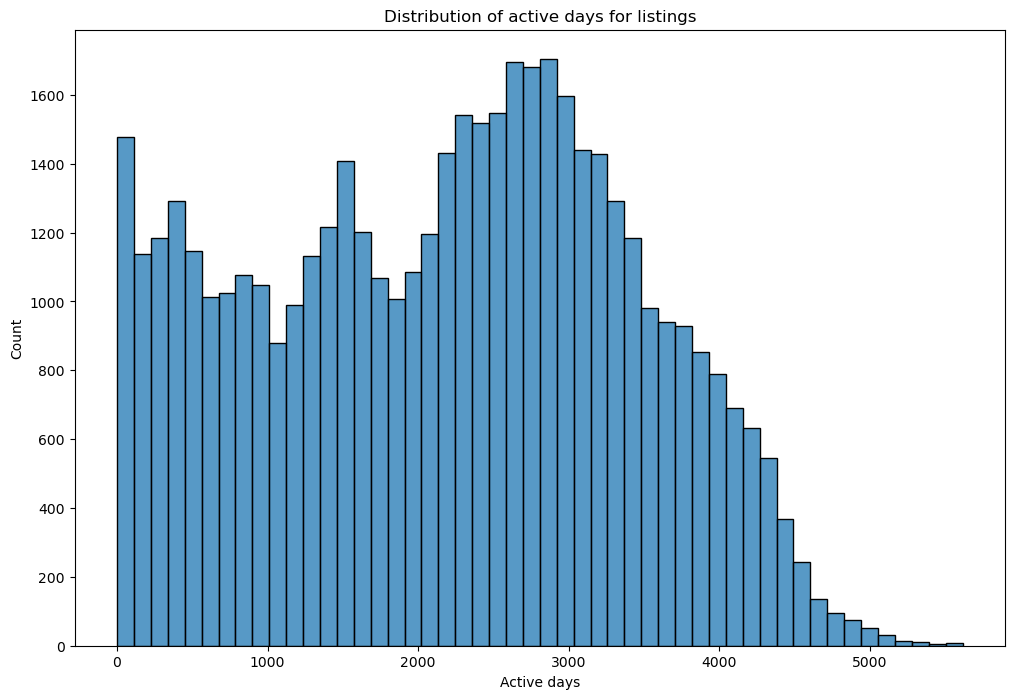

In [17]:
plt.figure(figsize=(12, 8))
sns.histplot(df['active_duration_days'], bins=50)
plt.xlabel('Active days')
plt.ylabel('Count')
plt.title('Distribution of active days for listings');

Typically, if listings have a small active day number, they should have small number of reviews as well. Let us take a look at lisitngs with less than 100 days active days.

In [18]:
df[(df['active_duration_days'] <= 100) & (df['number_of_reviews'] >50)][['active_duration_days', 'number_of_reviews']]

,active_duration_days,number_of_reviews
450,22.0,232
1559,28.0,214


Let us remove these listings as there is something wrong here (most likely the data for host joined has changed).

In [19]:
df = df[~((df['active_duration_days'] <= 100) & (df['number_of_reviews'] >50))]
df.shape

(47037, 77)

We can now start to estimate the occupancy rates for different review rates. As mentioned before, we have capped the occupancy rate to 70% per maximum occupancy of popular hotels and short term stays.

In [20]:
# occ_rate_70 is the occupancy rate assuming 70 percent of the guests leave a review

df['occ_rate_70'] = df.apply(lambda x: min(x['number_of_reviews'] / 0.7 
                                           * max(x['minimum_nights'], 5) / x['active_duration_days']
                                           , 0.7), axis=1)

In [21]:
df['occ_rate_70'].describe()

count    47037.000000
mean         0.189579
std          0.218192
min          0.001322
25%          0.027211
50%          0.091128
75%          0.279446
max          0.700000
Name: occ_rate_70, dtype: float64

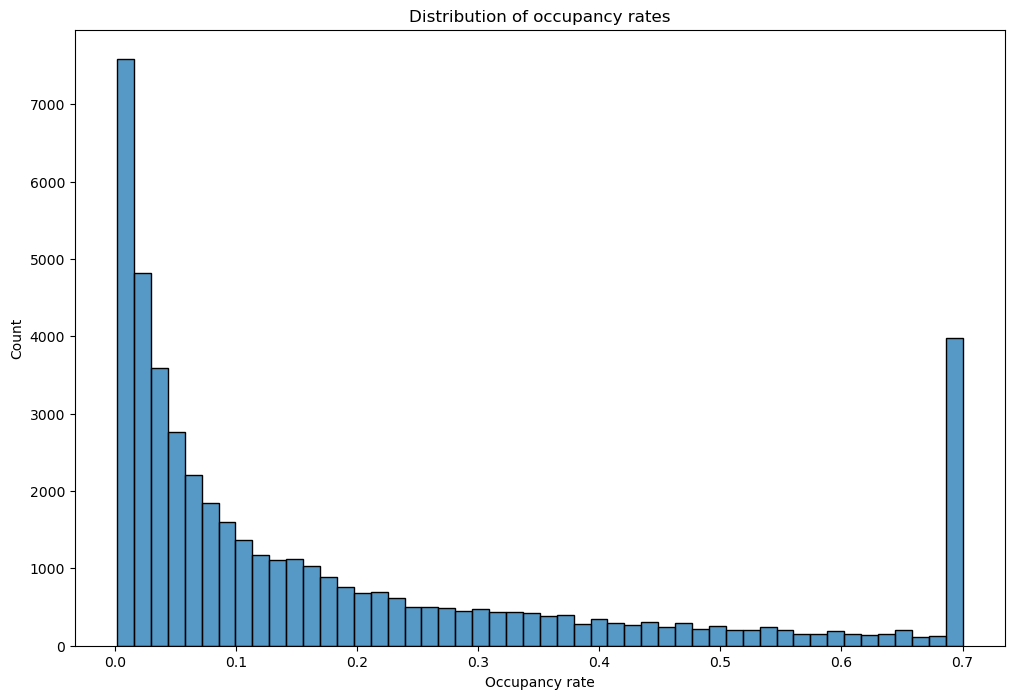

In [22]:
plt.figure(figsize=(12, 8))
sns.histplot(df['occ_rate_70'])
plt.xlabel('Occupancy rate')
plt.ylabel('Count')
plt.title('Distribution of occupancy rates');


In [23]:
df['occ_rate_70'].mean()

0.1895786703806457

Now, let us do the same calculations for review rates of 0.5 and 0.3 and look at all of the 4 models for occupancy rate calculations.

In [24]:
# occ_rate_50 is the occupancy rate assuming 50 percent of the guests leave a review
# occ_rate_30 is the occupancy rate assuming 50 percent of the guests leave a review
df['occ_rate_50'] = df.apply(lambda x: min(x['number_of_reviews'] / 0.5 
                                           * max(x['minimum_nights'], 5) / x['active_duration_days']
                                           , 0.7), axis=1)
df['occ_rate_30'] = df.apply(lambda x: min(x['number_of_reviews'] / 0.3 
                                           * max(x['minimum_nights'], 5) / x['active_duration_days']
                                           , 0.7), axis=1)

Mean occupancy rates for all of the 4 models we have used:

In [25]:
print(f"Average occupancy rate for using unavailable days in the calendar: {round(df['occ_rate_calendar'].mean(), 2)}")
print(f"Average occupancy rate for the model with a review rate of 70%: {round(df['occ_rate_70'].mean(), 2)}")
print(f"Average occupancy rate for the model with a review rate of 50%: {round(df['occ_rate_50'].mean(), 2)}")
print(f"Average occupancy rate for the model with a review rate of 30%: {round(df['occ_rate_30'].mean(), 2)}")

Average occupancy rate for using unavailable days in the calendar: 0.48
Average occupancy rate for the model with a review rate of 70%: 0.19
Average occupancy rate for the model with a review rate of 50%: 0.24
Average occupancy rate for the model with a review rate of 30%: 0.31


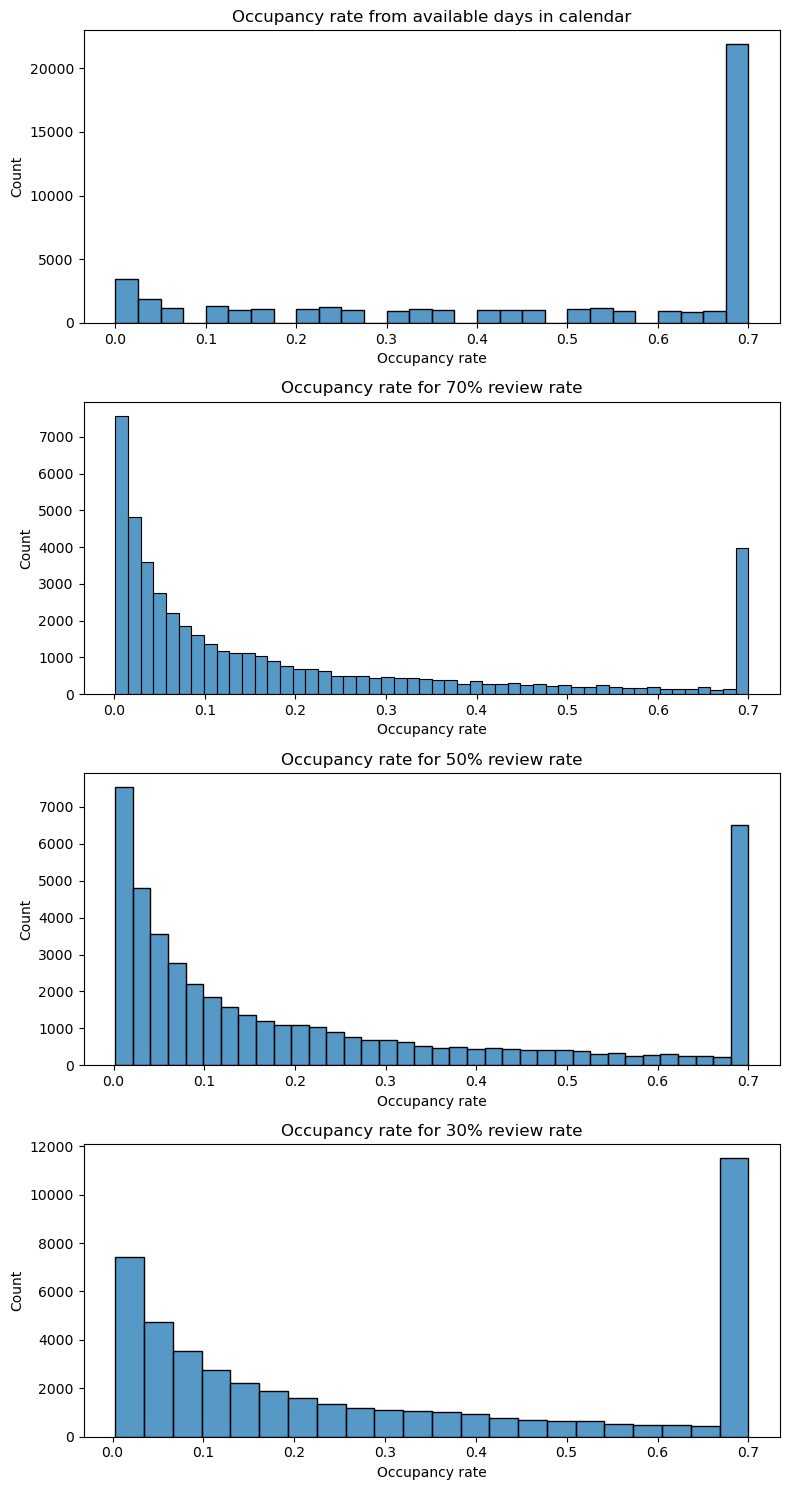

In [26]:
fig, axes = plt.subplots(4, figsize=(8, 15))
sns.histplot(df['occ_rate_calendar'], ax=axes[0])
axes[0].set_xlabel('Occupancy rate')
axes[0].set_title('Occupancy rate from available days in calendar')

sns.histplot(df['occ_rate_70'], ax=axes[1])
axes[1].set_xlabel('Occupancy rate')
axes[1].set_title('Occupancy rate for 70% review rate')

sns.histplot(df['occ_rate_50'], ax=axes[2])
axes[2].set_xlabel('Occupancy rate')
axes[2].set_title('Occupancy rate for 50% review rate')

sns.histplot(df['occ_rate_30'], ax=axes[3])
axes[3].set_xlabel('Occupancy rate')
axes[3].set_title('Occupancy rate for 30% review rate')

plt.tight_layout();

To sum up what have we done, we have used different occupancy models to estimate the occupancy rate based on the number of reviews for the listings. While assuming 70% seems very optimistic (for the percentage of guests who actually leave a review), 30% review rate would lead into the occupancy rates (and hence average income) that is not conservative enough. For these reasons, we have decided to go with the 50% review rates to estimate the occupancy rate. The mean occupancy rate of 25% percent from this model is comparable to what is currently reported by airbnb rental analysis websites about Austin market. 

## Listing time period

Our data has been scraped over a period of one year in which one scraped has performed every 3 months. 

In [27]:
df['last_scraped'].value_counts()

2023-06-11    11709
2023-09-10     9461
2023-03-16     8663
2023-12-16     8302
2023-12-17     3849
2023-03-17     2640
2023-09-11     2281
2023-12-15      104
2023-03-31       19
2023-12-26        9
Name: last_scraped, dtype: int64

In [31]:
df['last_scraped'].dtypes

dtype('<M8[ns]')